## 7.1 Test des saisons régulieres

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve, CalibrationDisplay
import joblib
from plot_metrics import *
from matplotlib.gridspec import GridSpec
import pickle

In [2]:



import numpy as np
import pandas as pd
#Charger le dataset
data = pd.read_csv("../data/Milestone2_data/Q4_test.csv")
data


#Séparer les données
data_reguliere = data[data["gameId"].apply(lambda x: str(x)[4:6] == "02")]
data_playoff = data[data["gameId"].apply(lambda x: str(x)[4:6] == "03")]

data_reguliere = data_reguliere.reset_index(drop=True)
data_playoff = data_playoff.reset_index(drop=True)
print(data_reguliere.columns)
print(data_playoff.columns)


Index(['gameId', 'period', 'shotType', 'coordinateX', 'coordinateY',
       'emptynet', 'lastEvent', 'lastCoordinateX', 'lastCoordinateY',
       'lastDistance', 'timeLastEvent', 'speed', 'rebound', 'distance',
       'angle', 'gameSeconds', 'chang_angle', 'non_gardiens_amicaux',
       'non_gardiens_adverses', 'isGoal'],
      dtype='object')
Index(['gameId', 'period', 'shotType', 'coordinateX', 'coordinateY',
       'emptynet', 'lastEvent', 'lastCoordinateX', 'lastCoordinateY',
       'lastDistance', 'timeLastEvent', 'speed', 'rebound', 'distance',
       'angle', 'gameSeconds', 'chang_angle', 'non_gardiens_amicaux',
       'non_gardiens_adverses', 'isGoal'],
      dtype='object')


In [5]:
test_reguliere=data_reguliere.iloc[:, 1:]
test_playoff=data_playoff.iloc[:, 1:]

In [7]:
data=test_reguliere

In [8]:
X_test = data[data.columns.tolist()[:-1]]
y_test = data[['isGoal']]
X_test

,period,shotType,coordinateX,coordinateY,emptynet,lastEvent,lastCoordinateX,lastCoordinateY,lastDistance,timeLastEvent,speed,rebound,distance,angle,gameSeconds,chang_angle,non_gardiens_amicaux,non_gardiens_adverses
0,1,6,-74.0,29.0,0,2,0,0,79.479557,86384,0.000920,0,32.649655,62.6501,16,0.0,5,5
1,1,6,49.0,-25.0,0,0,-58,-7,108.503456,86394,0.001256,0,47.169906,-32.0054,34,0.0,5,5
2,1,0,-52.0,-31.0,0,6,-87,-33,35.057096,86398,0.000406,0,48.270074,-39.9575,65,0.0,5,5
3,1,3,43.0,39.0,0,2,69,22,31.064449,86358,0.000360,0,60.307545,40.2921,171,0.0,5,5
4,1,2,-53.0,8.0,0,4,-66,4,13.601471,86399,0.000157,0,36.878178,12.5288,224,0.0,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52399,3,0,71.0,-16.0,0,6,-2,-33,74.953319,86379,0.000868,0,24.083189,-41.6335,3597,0.0,5,5
52400,4,6,-68.0,-14.0,0,2,0,0,69.426220,86367,0.000804,0,25.238859,-33.6901,3633,0.0,3,3
52401,4,6,56.0,11.0,0,2,-69,-22,129.282636,86377,0.001497,0,34.785054,18.4349,3657,0.0,3,3
52402,4,6,73.0,6.0,0,4,-30,33,106.480045,86382,0.001233,0,17.088007,20.5560,3706,0.0,3,3


In [9]:
y_test = data[['isGoal']]
y_test

,isGoal
0,0
1,0
2,0
3,0
4,0
...,...
52399,0
52400,0
52401,0
52402,0


In [10]:
def pred_model(X_test, y_test, model, folder=""):
    if model == 'LR_D':
        best_model = joblib.load("log_reg_distance_model.pkl")
        X_test = X_test[['distance']]
        
    elif model == 'LR_A':
        best_model = joblib.load("log_reg_angle_model.pkl")
        X_test = X_test[['angle']]
        
    elif model == 'LR_DA':
        best_model = joblib.load("log_reg_distance_angle_model.pkl")
        X_test = X_test[['distance', 'angle']]
        
    elif model == 'XGB':
        best_model = joblib.load("xgb_toutes_chars_grid_search1.pkl")
       
    elif model == 'Light_GBM':
        best_model = joblib.load("lightgbm_model.pkl")

   

    else:
        pass 

    y_pred = best_model.predict(X_test)
    
    #Probability estimates
    pred_probs = best_model.predict_proba(X_test)
    probs_isgoal = pred_probs[:,1]
    
    #Model Evaultion Metrics
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred)
    #precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    cf_matrix = metrics.confusion_matrix(y_test,y_pred)
    roc_auc = metrics.roc_auc_score(y_test,probs_isgoal)
    
    #print(f' accuracy: {accuracy}')
    #print(f' f1_score: {f1_score}')
    #print(f' precision: {precision}')
    #print(f' recall: {recall}')
    #print(f' roc_auc: {roc_auc}')
    #print('Confusion Matrix')
    #print(cf_matrix)
                                
    return y_test, y_pred, accuracy, pred_probs

In [23]:
def plot_roc_all_feat(X_test, y_test):
    fig = plt.figure(figsize=(12, 10))
    
    model_list = ['LR_D', 'LR_A', 'LR_DA', 'XGB', 'Light_GBM']  # Use correct model names
    model_color_list = ['red', 'blue', 'green', 'magenta', 'brown']
    
    for i, model in enumerate(model_list):
        print("Processing model:", model)
        try:
            if model != "NN":
                y_test, y_pred, accuracy, pred_probs = pred_model(X_test, y_test, model, "../model/")
                if pred_probs is None:
                    print(f"Skipping model {model}: Prediction probabilities are None.")
                    continue
                probs_isgoal = pred_probs[:, 1]
                fpr, tpr, _ = roc_curve(y_test, probs_isgoal)
            else:
                # Handle NN separately
                with open("../6_Different_Models/NN/results_nn_regular.pkl", 'rb') as file:
                    res = pickle.load(file)
                fpr, tpr, _ = roc_curve(y_test, res["y_"])
            
            roc_auc = auc(fpr, tpr)
            plot_color = model_color_list[i]
            plot_label = model_list[i]
            plt.plot(fpr, tpr, color=plot_color, label=f'{plot_label} AUC = {roc_auc:.2f}', lw=2)
        
        except Exception as e:
            print(f"Error processing model {model}: {e}")
    
    plt.title('ROC Curves', fontsize=20)
    plt.legend(loc=2, prop={'size': 16})
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('../figures/Milestone_2/7-1-1a_ROC_curves-reguliere.png')
    plt.show()


Processing model: LR_D
Processing model: LR_A
Processing model: LR_DA
Processing model: XGB
Processing model: Light_GBM


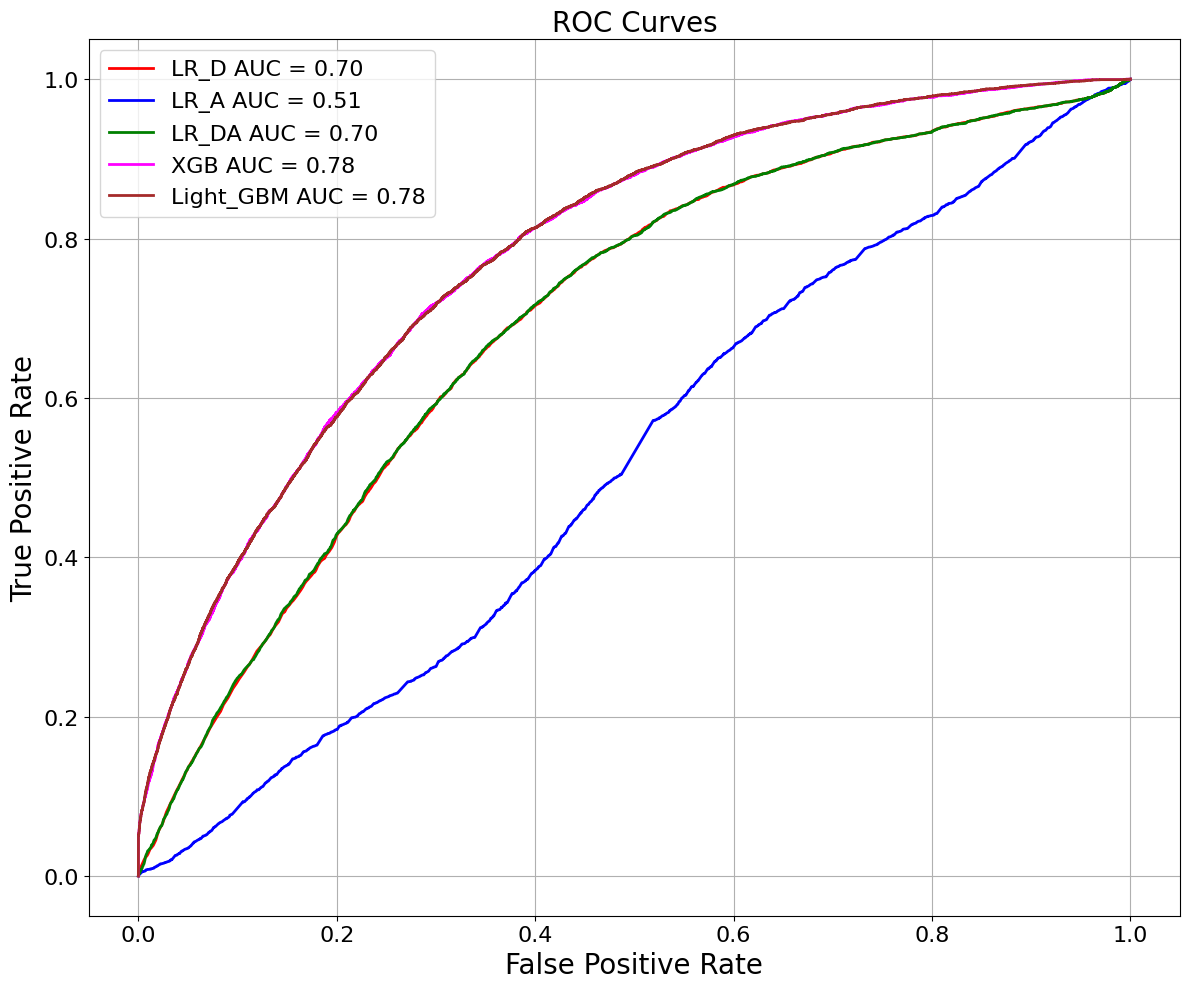

In [29]:
plot_roc_all_feat(X_test, y_test)

In [27]:
def plot_goal_rate_all_feat(X_test, y_test):  
    fig = plt.figure(figsize=(12,10))
    model_list = ['LR_D', 'LR_A', 'LR_DA', 'XGB','Light_GBM' ]
    model_color_list = ['red', 'blue', 'green', 'magenta', 'brown']
    
    for i, model in enumerate(model_list):
        print(model)
        if model != "NN":
            y_test, y_pred, accuracy,  pred_probs = pred_model(X_test, y_test, model, "../model/")  
            df_percentile =  calc_percentile(pred_probs, y_test)
        else:
            file = open("../6_Different_Models/NN/results_nn_regular.pkl",'rb')
            res = pickle.load(file)
            file.close()
            df_percentile = calc_percentile(res["pred_probs"], y_test)

        goal_rate_df = goal_rate(df_percentile)
        goal_rate_x = goal_rate_df['Percentile']
        goal_rate_y = goal_rate_df['Rate']
        plot_color = model_color_list[i]
        plot_label = model_list[i]
        plt.plot(goal_rate_x,goal_rate_y, color = plot_color, label = f'{plot_label}' )
                 
       
    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    
    ax.set_ylim([0,100])
    ax.set_xlim([0,100])
    ax.invert_xaxis()
    major_ticks = np.arange(0, 110, 10)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    
    plt.grid(True)
    plt.title('Goal Rate', fontsize=20)
    plt.xlabel('Shot probability model percentile', fontsize=16)
    plt.ylabel('Goals / (Shots+Goals)%', fontsize=16)
    plt.legend(loc=2,prop={'size': 16})
    plt.tight_layout()
    plt.savefig(f'../figures/Milestone_2/7-1-1b_goal_rates-reguliere.png')
    plt.show()

LR_D
LR_A
LR_DA
XGB
Light_GBM


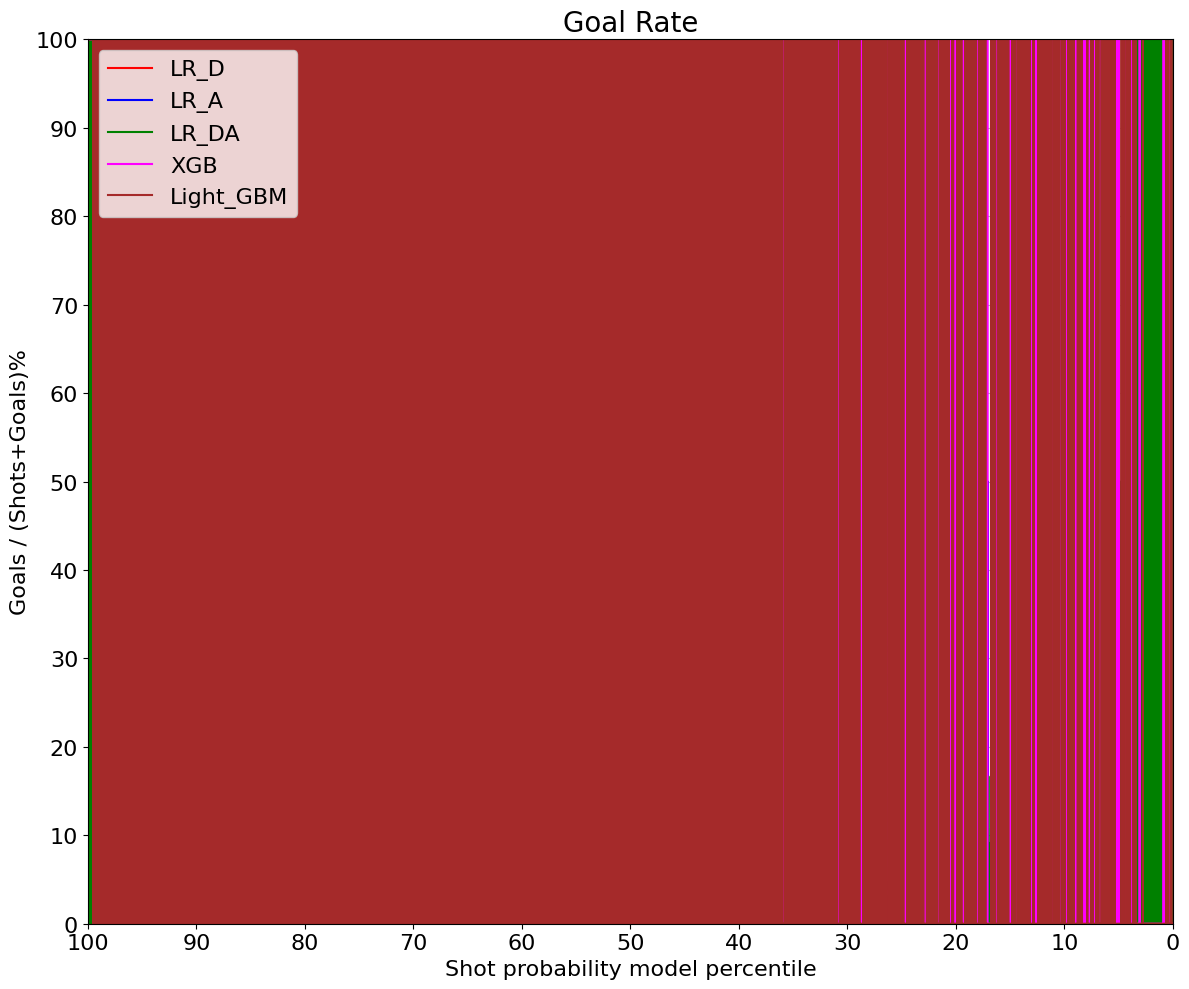

In [28]:
plot_goal_rate_all_feat(X_test, y_test)

In [25]:
def plot_cumulative_rate_all_feat(X_test, y_test):

    fig = plt.figure(figsize=(12,10))
    model_list = ['LR_D', 'LR_A', 'LR_DA', 'XGB', 'Light_GBM']
    model_color_list = ['red', 'blue', 'green', 'magenta', 'brown']
    
    
    for i, model in enumerate(model_list):
        print(model)

        if model != "NN":
            y_test, y_pred, accuracy,  pred_probs = pred_model(X_test, y_test, model, "../model/") 
            df_percentile = calc_percentile(pred_probs, y_test)
        else:
            file = open("../6_Different_Models/NN/results_nn_regular.pkl",'rb')
            res = pickle.load(file)
            file.close()
            df_percentile = calc_percentile(res["pred_probs"], y_test)
            
        df_precentile_only_goal = df_percentile[df_percentile['isGoal'] == 1]
        
        plot_color = model_color_list[i]
        plot_label = model_list[i]
        ax = sns.ecdfplot(data=df_precentile_only_goal, x=100 - df_precentile_only_goal.Percentile, 
                              color=plot_color)
            
    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    plt.yticks(np.arange(0, 1.05, 0.1))
    plt.xticks(np.arange(0, 100 * 1.01, 10))
    xvals = ax.get_xticks()
    ax.set_xticklabels(100 - xvals.astype(np.int32), fontsize=16)
    yvals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(y) for y in yvals], fontsize=16)
    ax.set_xlabel('Shot probability model percentile', fontsize=16)
    ax.set_ylabel('Proportion', fontsize=16)
    ax.set_title(f"Cumulative % of Goals", fontsize=20)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    
    
    plt.legend(labels=model_list, fontsize=16)
    plt.tight_layout()
    plt.savefig(f'../figures/Milestone_2/7-1-1c_goal_proportionsreguliere.png')
    plt.show()

LR_D
LR_A
LR_DA
XGB
Light_GBM


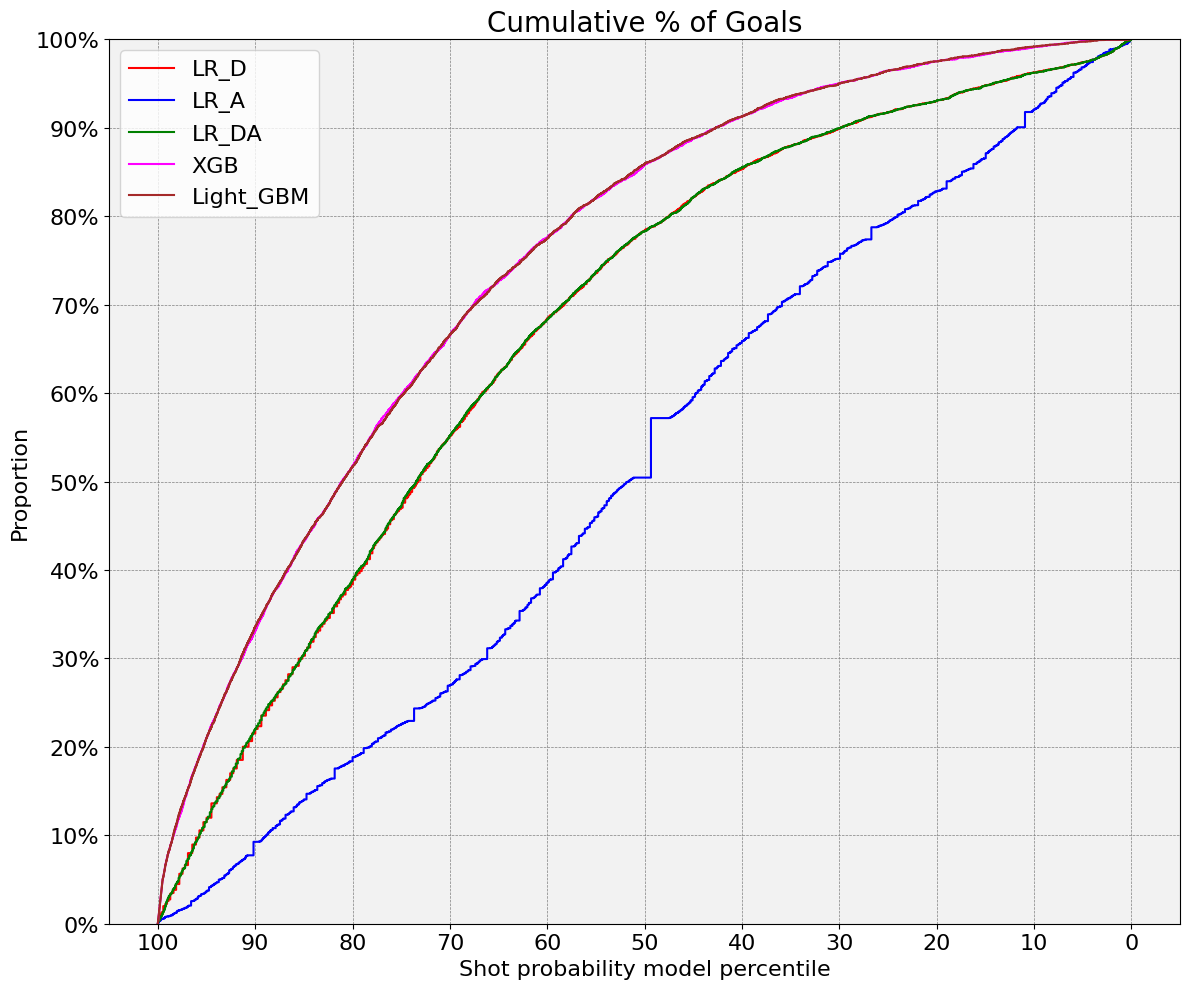

In [30]:
plot_cumulative_rate_all_feat(X_test, y_test)

In [26]:
def plot_calibration_all_feat(X_test, y_test):

    fig = plt.figure(figsize=(20, 20))
    gs = GridSpec(4, 3)

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    
    model_list = ['LR_D', 'LR_A', 'LR_DA', 'XGB', 'Light_GBM']
    model_color_list = ['red', 'blue', 'green', 'magenta', 'brown', 'cyan', "orange", "yellow"]
    
    for i, model in enumerate(model_list):
        print(model)

        if model != "NN":
            y_test, y_pred, accuracy,  pred_probs = pred_model(X_test, y_test, model, "../model/")
            y_test_is_goal = y_test['isGoal']
            probs_isgoal = pred_probs[:,1]
        else:
            file = open("../6_Different_Models/NN/results_nn_regular.pkl",'rb')
            res = pickle.load(file)
            file.close()
            probs_isgoal = res["y_"]

        plot_color = model_color_list[i]
        plot_label = model_list[i] 
        ax_display = CalibrationDisplay.from_predictions(y_test_is_goal,probs_isgoal, n_bins=50,                                                           ax=ax_calibration_curve, color=plot_color, label=plot_label)
   
    ax = plt.gca()
    ax.set_facecolor('0.95')
    ax_calibration_curve.grid()
    
    plt.title("Calibration plots", fontsize=20)
    plt.legend(loc=2,prop={'size': 16})
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.ylabel('Fraction of positives', fontsize=20)
    plt.xlabel('Mean predicted probability', fontsize=20)
    plt.tight_layout()
    plt.savefig(f'../figures/Milestone_2/7-1-1d_calibration_plots-reguliere.png')
    plt.show()

LR_D
LR_A
LR_DA
XGB
Light_GBM


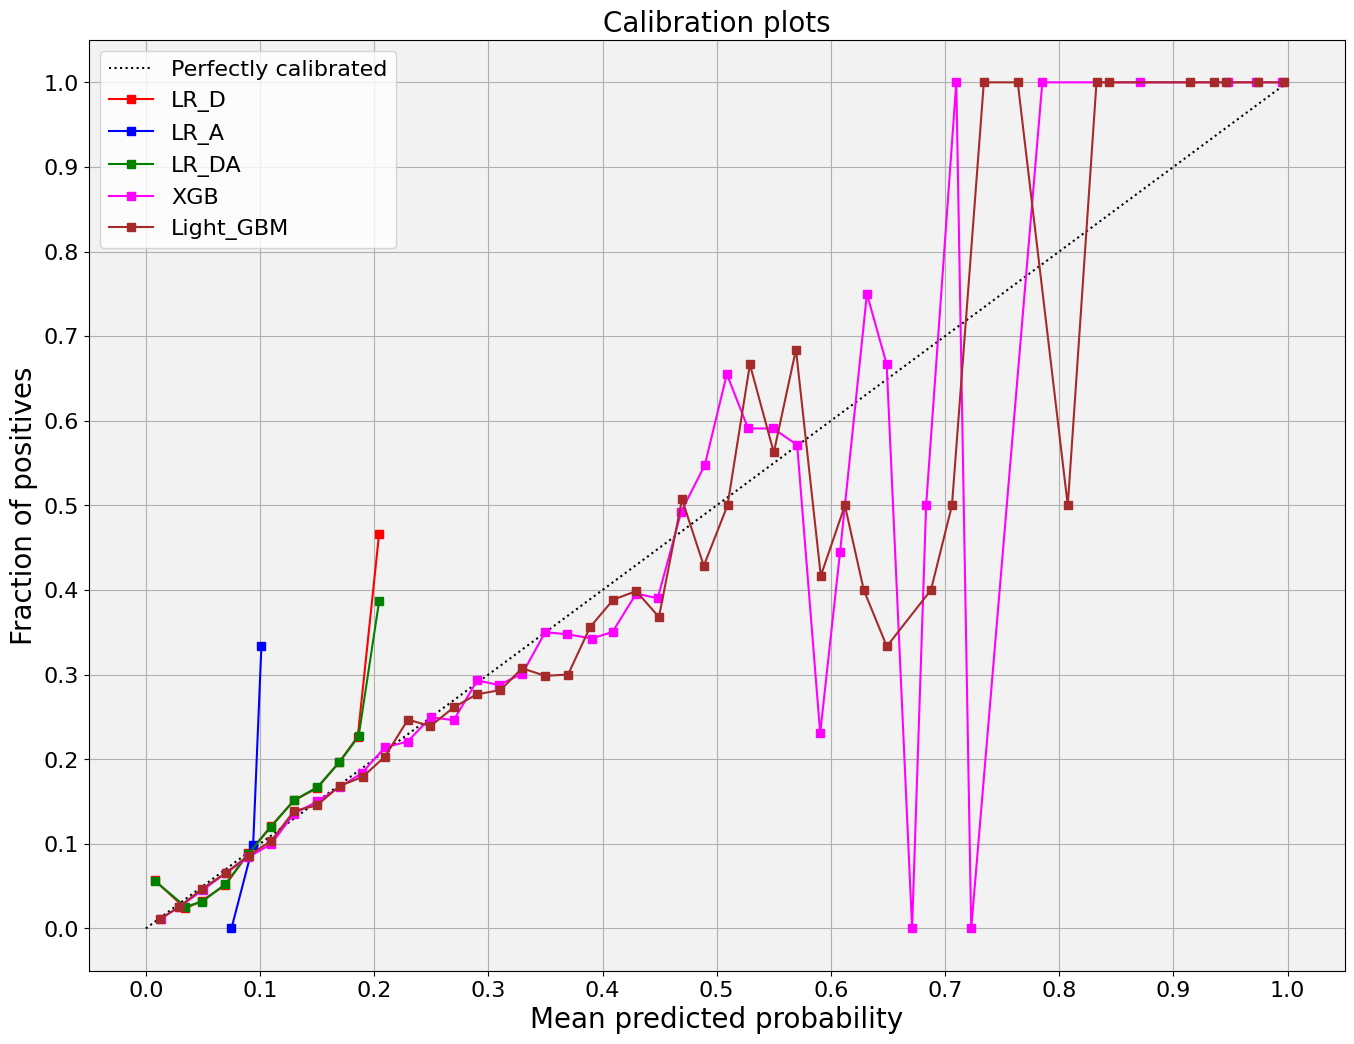

In [31]:
plot_calibration_all_feat(X_test, y_test)

In [22]:
def calc_percentile(pred_probs, y_val):
    
    # Créer un DataFrame pour les probabilités de tir
    df_probs = pd.DataFrame(pred_probs)
    df_probs = df_probs.rename(columns={0: "Probabilité_Non_But", 1: "Probabilité_But"})
    
    # Combiner la 'Probabilité de But' et 'Est But' dans un seul DataFrame
    df_probs = pd.concat([df_probs["Probabilité_But"].reset_index(drop=True), y_val["isGoal"].reset_index(drop=True)], axis=1)
    
    # Calculer et ajouter la colonne de Percentile
    valeurs_percentile = df_probs['Probabilité_But'].rank(pct=True)
    df_probs['Percentile'] = valeurs_percentile * 100
    df_percentile = df_probs.copy()
    
    return df_percentile


In [4]:
def goal_rate(df_percentile):
    """
    Calculate goal rates for each percentile group.
    """
    # Group by percentile and calculate mean goal rate
    goal_rate_df = df_percentile.groupby('Percentile').agg(
        Rate=('isGoal', 'mean')
    ).reset_index()

    # Convert to percentages if needed
    goal_rate_df['Rate'] *= 100
    return goal_rate_df
